In [48]:
from datetime import datetime, timedelta
from metloom.pointdata import SnotelPointData
import pandas as pd
import geopandas as gpd
import xarray as xr
from metsim import MetSim
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from metpy.units import units
import metpy.calc as mpcalc
import math
import scipy
import os
import shutil
from pytz import UTC
from matplotlib.font_manager import FontProperties
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
from datetime import datetime
import pysumma.plotting as psp


In [49]:
# start_date = datetime(2022, 10, 1)
# end_date = datetime(2023, 9, 30)

# # Pull desired variables from snotel to dataframe
# snotel_point = SnotelPointData('380:CO:SNTL', "MyStation")
# df = snotel_point.get_hourly_data(
#     start_date, end_date,
#     [snotel_point.ALLOWED_VARIABLES.PRECIPITATIONACCUM, snotel_point.ALLOWED_VARIABLES.TEMP, snotel_point.ALLOWED_VARIABLES.SNOWDEPTH]
# )

# # Specify latitude, longitude, and elevation from station metadata
# lat = snotel_point.metadata.y
# lon = snotel_point.metadata.x
# elev = snotel_point.metadata.z

# # Clean up the dataframe
# df.reset_index(inplace=True)

# # Rename columns
# replace = {'ACCUMULATED PRECIPITATION':'accppt','AIR TEMP':'airtemp', 'datetime':'time'}
# df.rename(columns=replace, inplace=True)
# df.set_index('time', inplace=True)

# # add 'SNOWDEPTH' and 'SNOWDEPTH_units' to the droplist if it decides to work again
# try:
#     df.drop(columns=['site', 'ACCUMULATED PRECIPITATION_units', 'geometry', 'AIR TEMP_units', 'datasource', 
#                  'SWE', 'SWE_units', 'SNOWDEPTH', 'SNOWDEPTH_units'], inplace=True)
# except:
#     df.drop(columns=['site', 'ACCUMULATED PRECIPITATION_units', 'geometry', 'AIR TEMP_units', 'datasource'], inplace=True)
#     print('SNOTEL csv has no snowdepth for this run')

In [50]:
# df.to_csv('/home/cdalden/summa_setup/analysis/ollalie_snotel_obs_2000to2024.csv')

In [51]:
df = pd.read_csv('/home/cdalden/summa_setup/analysis/ollalie_snotel_obs_2000to2024.csv', parse_dates=True, index_col='time')

In [52]:
# subset the dataframe to only include the desired years
df = df.loc['2023-12-01':'2024-01-10']

# convert air temp to celsius
df['airtemp'] = (df['airtemp'] - 32) * 5/9  # convert to celsius

# calculate precipitation rate
df['pptrate'] = df['accppt'].diff()  # calculate precipitation rate
df['pptrate'] = df['pptrate'] * 25.4  # convert to mm
# set negative values to 0
df['pptrate'] = df['pptrate'].clip(lower=0)
df_daily = df.resample('D').sum()

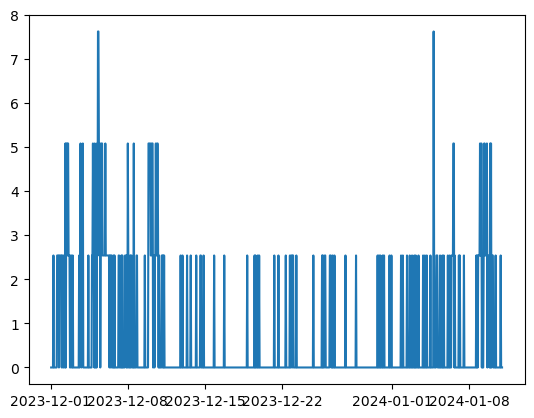

In [53]:
plt.plot(df.index, df['pptrate'])

In [54]:
file_name = 'olallie_current_WY24'
ds = xr.open_dataset(f'/home/cdalden/summa_setup/model/output/output_{file_name}_timestep.nc')

time_range = slice('12-01-2023', '01-10-2024')
depth      =    ds.isel(hru=0).sel(time=time_range)['iLayerHeight']
temp       =    ds.isel(hru=0).sel(time=time_range)['mLayerTemp']
temp       =    temp.where((temp == -9999) | np.isnan(temp), temp - 273.15)
frac_liq   =    ds.isel(hru=0).sel(time=time_range)['mLayerVolFracLiq']
frac_wat   =    ds.isel(hru=0).sel(time=time_range)['mLayerVolFracWat']
frac_wat   =    frac_wat.where((frac_wat == -9999) | np.isnan(frac_wat), frac_wat * 1000)
snow_depth =    ds.isel(hru=0).sel(time=time_range)['scalarSnowDepth']

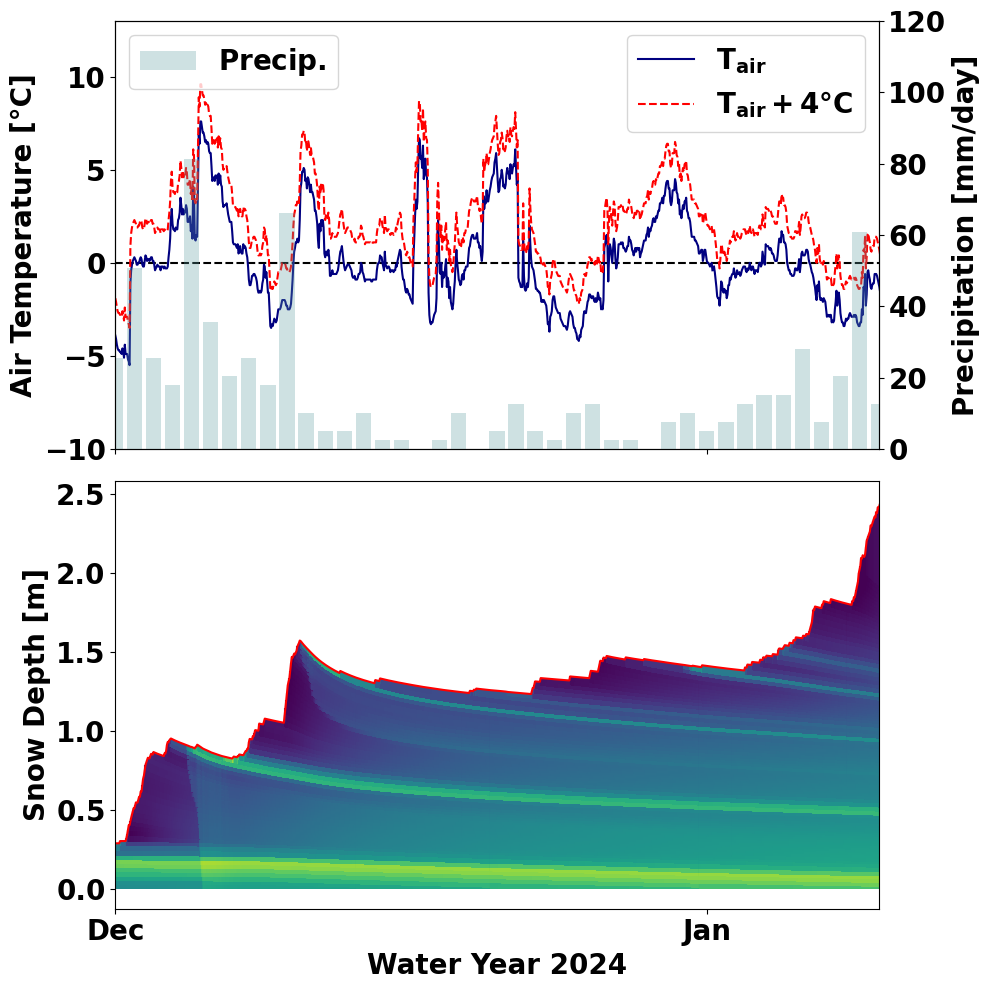

In [58]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Plot airtemp on the primary y-axis
ax[0].plot(df.index, df['airtemp'], c='navy', label=r'$\mathbf{T_{air}}$')
ax[0].plot(df.index, df['airtemp'] + 2, c='red', label=r'$\mathbf{T_{air}+4\degree C}$', ls='--')
ax[0].axhline(0, color='k', linestyle='--', zorder=1)

# Create a secondary y-axis for pptrate
ax2 = ax[0].twinx()
# ax2.bar(df.index, df['pptrate'], color='cadetblue', alpha=0.3, width=0.1, label='Precip.')
ax2.bar(df_daily.index, df_daily['pptrate'], color='cadetblue', alpha=0.3, width=0.8, label=r'$\mathbf{Precip.}$')
ax2.set_ylabel('Precipitation [mm/day]', fontsize=20, fontweight='bold')
ax2.set_ylim(0, 120)

ax[0].set_ylabel('Air Temperature [°C]', fontsize=20, fontweight='bold')
# ax[0].set_xlabel('Water Year 2024', fontsize=20, fontweight='bold')

# plot only for dec 2023 to march 2024
ax[0].set_xlim(datetime(2023, 12, 1), datetime(2024, 1, 10))
ax[0].set_ylim(-10, 13)

ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[0].xaxis.set_major_locator(mdates.MonthLocator())

# Set tick labels bold and size 20
font_properties = FontProperties(weight='bold', size=20)
for label in ax[0].get_xticklabels() + ax[0].get_yticklabels():
    label.set_fontproperties(font_properties)

for label in ax2.get_xticklabels() + ax2.get_yticklabels():
    label.set_fontproperties(font_properties)

ax[0].legend(fontsize=20, loc='upper right', prop=font_properties)
ax2.legend(fontsize=20, loc='upper left', prop=font_properties)



psp.layers(frac_wat, depth, plot_soil=False, variable_range=[100, 600], ax=ax[1])

ax[1].plot(snow_depth.time, snow_depth, c='r')
ax[1].set_xlabel('Water Year 2024', fontweight='bold', fontsize=20)
ax[1].set_ylabel('Snow Depth [m]', fontweight='bold', fontsize=20)

# Set the date format for x-axis
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# Ensure each month is only plotted once
ax[1].xaxis.set_major_locator(mdates.MonthLocator())

# Change the fontsize and fontweight of x tick labels
font_properties = FontProperties(weight='bold', size=20)
for label in ax[1].get_xticklabels() + ax[1].get_yticklabels():
    label.set_fontproperties(font_properties)



plt.tight_layout()
plt.savefig(f'/home/cdalden/summa_setup/analysis/figures/conceptual_crust_diagram.png', dpi=300)
